Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer
import visualkeras


Load Data:

In [2]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.read_csv('Embeddings/ESM_650/train_esm650.csv')
# val = pd.read_csv('Embeddings/ESM_650/val_esm650.csv')
# test = pd.read_csv('Embeddings/ESM_650/test_esm650.csv')

# train = pd.concat([train, val])

# train, val = train_test_split(train, test_size=0.1, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)


# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(935, 1024)
(3226, 1024)
(8411, 20)
(935, 20)
(3226, 20)
(8411, 33)
(935, 33)
(3226, 33)
(8411,)
(935,)
(3226,)


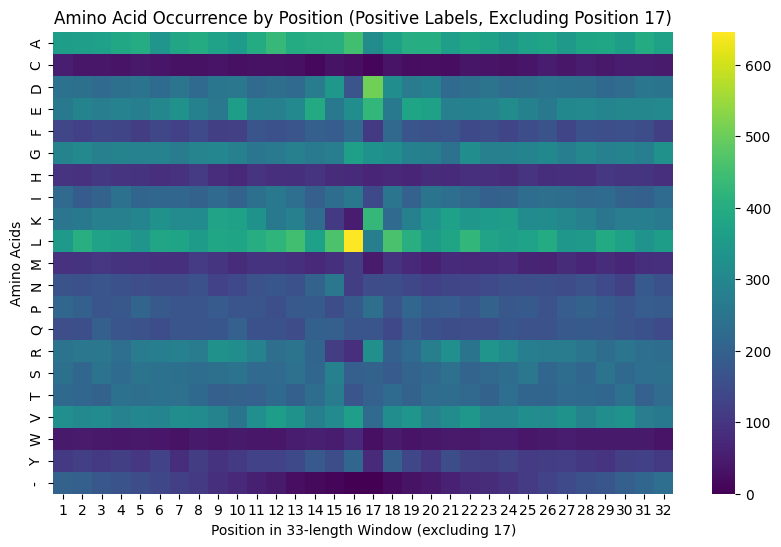

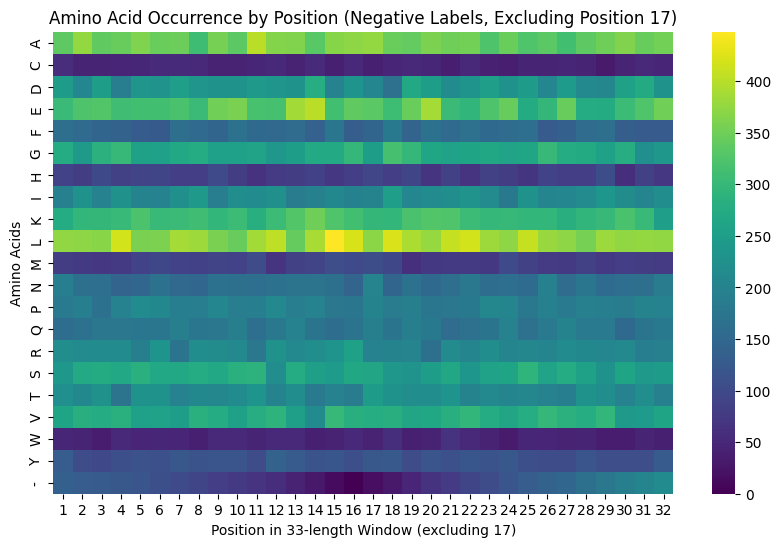

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define amino acids and initialize the count matrices
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Separate sequences by labels
positive_sequences = X_train[y_train == 1]
negative_sequences = X_train[y_train == 0]

# Initialize count matrices for positive and negative labels
positive_counts = np.zeros((len(amino_acids), 32), dtype=int)  # 32 positions now
negative_counts = np.zeros((len(amino_acids), 32), dtype=int)  # 32 positions now

# Count occurrences for positive sequences
for seq in positive_sequences:
    modified_seq = seq[:16] + seq[17:]  # Exclude the 17th amino acid
    for position, aa in enumerate(modified_seq):
        if aa in aa_to_int:
            positive_counts[aa_to_int[aa], position] += 1

# Count occurrences for negative sequences
for seq in negative_sequences:
    modified_seq = seq[:16] + seq[17:]  # Exclude the 17th amino acid
    for position, aa in enumerate(modified_seq):
        if aa in aa_to_int:
            negative_counts[aa_to_int[aa], position] += 1

# Plot heatmap for positive labels
plt.figure(figsize=(10, 6))
sns.heatmap(positive_counts, annot=False, cmap="viridis", xticklabels=range(1, 33), yticklabels=amino_acids)
plt.title('Amino Acid Occurrence by Position (Positive Labels, Excluding Position 17)')
plt.xlabel('Position in 33-length Window (excluding 17)')
plt.ylabel('Amino Acids')
plt.show()

# Plot heatmap for negative labels
plt.figure(figsize=(10, 6))
sns.heatmap(negative_counts, annot=False, cmap="viridis", xticklabels=range(1, 33), yticklabels=amino_acids)
plt.title('Amino Acid Occurrence by Position (Negative Labels, Excluding Position 17)')
plt.xlabel('Position in 33-length Window (excluding 17)')
plt.ylabel('Amino Acids')
plt.show()


In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Function to compute amino acid count matrix (excluding position 17)
def compute_amino_acid_counts(sequences):
    counts = []
    for seq in sequences:
        modified_seq = seq[:16] + seq[17:]  # Exclude position 17
        count_matrix = np.zeros((len(amino_acids), 32), dtype=int)
        for position, aa in enumerate(modified_seq):
            if aa in aa_to_int:
                count_matrix[aa_to_int[aa], position] += 1
        counts.append(count_matrix.flatten())  # Flatten the matrix
    return np.array(counts)

# Compute features for training
X_train = compute_amino_acid_counts(X_train)
y = y_train  # Labels

X_test = compute_amino_acid_counts(X_test)
y_test = y_test  # Labels

# Split data into training and validation sets

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.638561686298822

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76      2973
           1       0.14      0.73      0.24       253

    accuracy                           0.64      3226
   macro avg       0.55      0.68      0.50      3226
weighted avg       0.90      0.64      0.72      3226



In [5]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [6]:
def plot_roc_pr (title, y_true, y_prob, aucs, auprcs):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(title+'_roc.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(title+'_PR.pdf', format='pdf', bbox_inches='tight')

    plt.show()
    

In [7]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import shap
import numpy as np
def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)    
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x
# Define the Conv branch model separately
def create_conv_branch(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Embedding(input_dim=21, output_dim=21)(input_layer)
    x = residual_block(x, 32)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, 64)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=input_layer, outputs=x)

# Specify the input shape for your Conv branch
input_shape_conv = (33,)  # Adjust this based on your data
conv_branch_model = create_conv_branch(input_shape_conv)

conv_branch_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = conv_branch_model.fit(X_train_num, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_val_num, y_val))

evaluate_model(conv_branch_model, X_val_num, None, None, y_val)
evaluate_model(conv_branch_model, X_test_num, None, None, y_test)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.5262 - val_loss: 0.6923
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5237 - loss: 0.6924 - val_accuracy: 0.5840 - val_loss: 0.6917
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5581 - loss: 0.6911 - val_accuracy: 0.5947 - val_loss: 0.6903
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5784 - loss: 0.6883 - val_accuracy: 0.5251 - val_loss: 0.6885
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5858 - loss: 0.6822 - val_accuracy: 0.6471 - val_loss: 0.6701
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6296 - loss: 0.6621 - val_accuracy: 0.6599 - val_loss: 0.6354
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6586 - loss: 0.6256 - val_accuracy: 0.6706 - val_loss: 0.6109
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6664 - loss: 0.6140 - val_accu

(0.6602603843769373,
 0.25058162042931925,
 0.8061187047059902,
 0.2625531017912403,
 0.1630695443645084,
 0.8063241106719368,
 0.6478304742684158,
 0.2712765957446808)

In [9]:
from Bio.PDB import PDBParser
from Bio import SeqIO
import numpy as np

# Function to extract the sequence from a FASTA file
def get_sequence(protein_id, site, fasta_file, window_size=16, pad_char='-'):
    with open(fasta_file) as fasta:
        for record in SeqIO.parse(fasta, 'fasta'):
            if record.id == protein_id:
                seq = record.seq
                site = int(site)

                # Calculate start and end indices
                start = max(0, site - window_size - 1)
                end = min(len(seq), site + window_size)

                # Extract the sequence
                extracted_seq = str(seq[start:end])

                # Calculate padding needed on the left and right
                left_padding = max(0, window_size - site + 1)
                right_padding = max(0, (site + window_size) - len(seq))

                # Add padding if necessary
                padded_seq = (pad_char * left_padding) + extracted_seq + (pad_char * right_padding)

                return padded_seq
    return None

# Function to calculate distances within a 33-residue window
def calculate_distances(protein_id, site, pdb_file, window_size=16):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(protein_id, pdb_file)
    
    # Store CA atom coordinates for the residues in the specified window
    ca_coords = []
    target_coord = None
    for model in structure:
        for chain in model:
            residues = list(chain.get_residues())
            
            # Find the index of the target site in residues list
            target_index = None
            for i, residue in enumerate(residues):
                if residue.get_id()[1] == site:
                    target_index = i
                    break
            
            if target_index is not None:
                # Calculate the window boundaries
                start = max(0, target_index - window_size)
                end = min(len(residues), target_index + window_size + 1)
                
                # Collect CA atom coordinates within the window
                for i in range(start, end):
                    residue = residues[i]
                    if "CA" in residue:
                        ca_atom = residue["CA"]
                        ca_coords.append((residue.get_id()[1], ca_atom.get_coord()))
                    
                    # Identify the target site's CA coordinates
                    if i == target_index:
                        target_coord = ca_atom.get_coord()
                break

    # Calculate distances from target to each residue within the window
    distances = {}
    if target_coord is not None:
        for res_id, coord in ca_coords:
            distance = np.linalg.norm(target_coord - coord)
            distances[res_id] = distance

    return distances

# Usage of functions
protein_id = train['protein_id'].values[6]
site = int(train['site'].values[6])

print("Protein ID:", protein_id, "Site:", site)

# File paths
fasta_file = 'data/full_sequences/all_sequence_cleaned.fasta'
pdb_file = f'PDB files new/{protein_id}.pdb'

# Get the sequence from FASTA file
sequence = get_sequence(protein_id, site, fasta_file)
print("Extracted sequence:", sequence)
print("Expected sequence from train data:", train['sequence'].values[6])

# Calculate distances
distances = calculate_distances(protein_id, site, pdb_file)
print("Distances from target site to residues in 33-residue window:", distances)

Protein ID: I6X9V3 Site: 321
Extracted sequence: TVVEHVELGPVALALLKRGLPGDTALVTGPEAE
Expected sequence from train data: TVVEHVELGPVALALLKRGLPGDTALVTGPEAE
Distances from target site to residues in 33-residue window: {305: 17.119081, 306: 18.524134, 307: 21.666918, 308: 24.28548, 309: 24.703053, 310: 28.21643, 311: 27.263824, 312: 23.65372, 313: 24.244043, 314: 21.54988, 315: 18.453028, 316: 15.658777, 317: 13.324411, 318: 9.798679, 319: 7.0706234, 320: 3.8238845, 321: 0.0, 322: 3.8248806, 323: 6.5870867, 324: 6.7289243, 325: 10.467079, 326: 11.883807, 327: 14.180689, 328: 11.792377, 329: 13.767723, 330: 12.124095, 331: 14.155302, 332: 14.432331, 333: 17.446712, 334: 19.530396, 335: 20.313896, 336: 17.245903, 337: 19.90981}


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Protein ID: Q16854 Site: 233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Protein ID: YGL167C Site: 372
Protein ID: P0A715 Site: 275
Protein ID: O88986 Site: 186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P0A8P3 Site: 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P18124 Site: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: I6X9V3 Site: 321
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Protein ID: P30750 Site: 9
Protein ID: YEL031W Site: 619
Protein ID: I6Y628 Site: 1122
Protein ID: F8VTL3 Site: 842
Protein ID: I6X5Y3 Site: 166
Protein ID: P0A715 Site: 156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Protein ID: S8FFS7 Site: 500
Protein ID: S8GCU3 Site: 547
Protein ID: YLR150W Site: 105
Protei

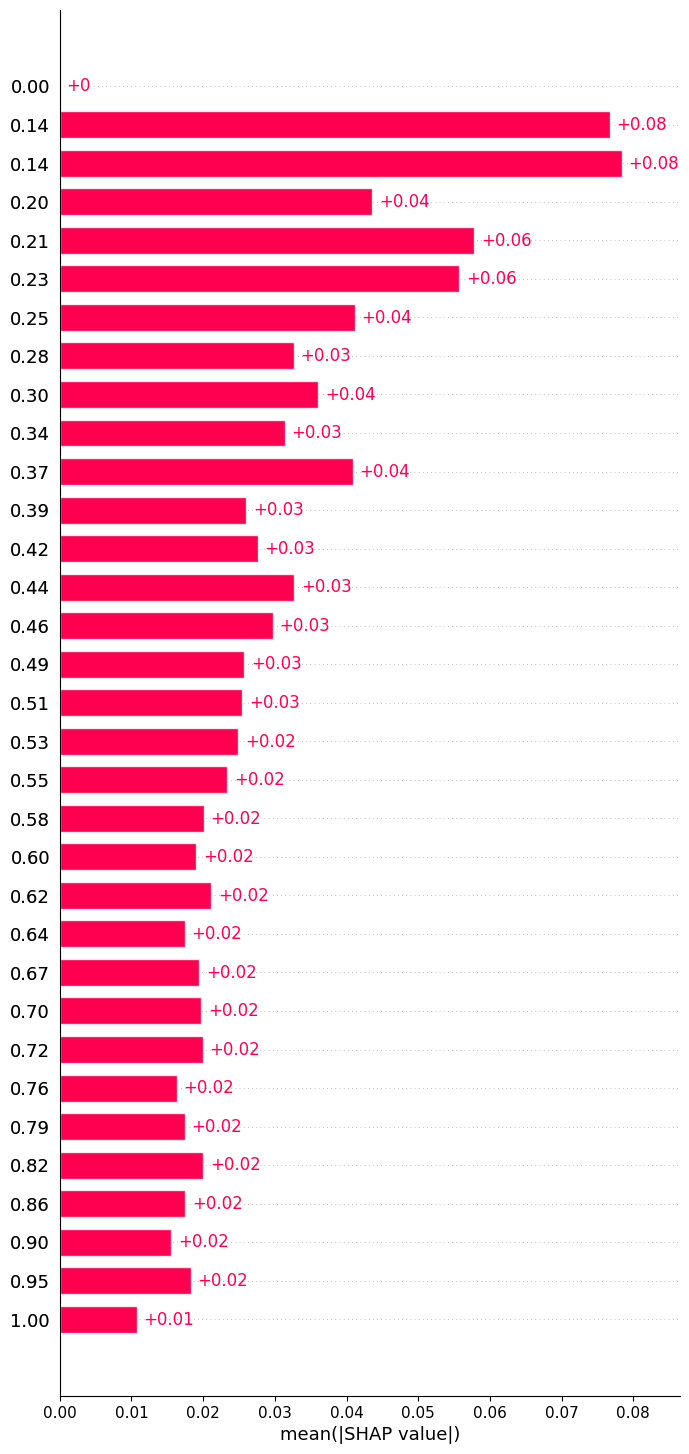

<Figure size 640x480 with 0 Axes>

In [10]:
import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select a single sample for SHAP analysis
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
# Initialize KernelExplainer for SHAP values
shap_explainer = shap.KernelExplainer(conv_branch_model.predict, X_train_num[:100])

# Initialize lists to store SHAP values, distances, and feature names for all proteins
all_shap_values = []
all_distance_values = []

# Assuming `proteins_data` is your dataset and `distances` is a dictionary with distance values for each protein
# For each protein in your dataset
for i in range (200):
    try:
        protein_id = train['protein_id'].values[i]
        site = int(train['site'].values[i])
        
        print("Protein ID:", protein_id, "Site:", site)
        # File paths
        pdb_file = f'PDB files new/{protein_id}.pdb'
        distances = calculate_distances(protein_id, site, pdb_file)
    except:
        continue

    if len(distances) != 33:
        continue
    data = train['sequence'].values[i]
    data = [aa_to_int[aa] for aa in data]
    data = np.array(data)
    shap_values = shap_explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values).squeeze())  # Take absolute SHAP values

    # Ensure the order of distances aligns with shap_values (sorted by position if needed)
    distance_values = np.array([distances[i] for i in sorted(distances.keys())])
    # Scale the distances
    distance_values = (distance_values - np.min(distance_values)) / (np.max(distance_values) - np.min(distance_values))

    # Sort both shap_values and distance_values by distance_values
    sorted_indices = np.argsort(distance_values)
    sorted_distance_values = distance_values[sorted_indices]
    sorted_shap_values = shap_values[sorted_indices]

    # Reshape if needed and create a SHAP Explanation object
    shap_values = sorted_shap_values.squeeze()  # Ensure correct shape for visualization
    all_shap_values.append(shap_values)
    all_distance_values.append(sorted_distance_values)

base_values = shap_explainer.expected_value  # Use model's expected output as base

with open('SHAP/all_shap_values_2.pkl', 'wb') as f:
    pickle.dump(all_shap_values, f)

mean_distance_values = np.mean(all_distance_values, axis=0)

# Format feature names based on the mean distance values
feature_names = [f"{dist:.2f}" for dist in mean_distance_values]

# Create the SHAP Explanation object without flattening
shap_values = shap.Explanation(
    values=all_shap_values,
    base_values=base_values,
    feature_names=feature_names
)

with open('SHAP/distance_shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

# Visualize SHAP values as a bar plot in original order
ordering = np.arange(len(feature_names))  # Preserve original order
shap.plots.bar(shap_values, max_display=len(feature_names), order=ordering)
plt.savefig("bar_plot.pdf", format="pdf")
plt.show()
plt.close()

    


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━

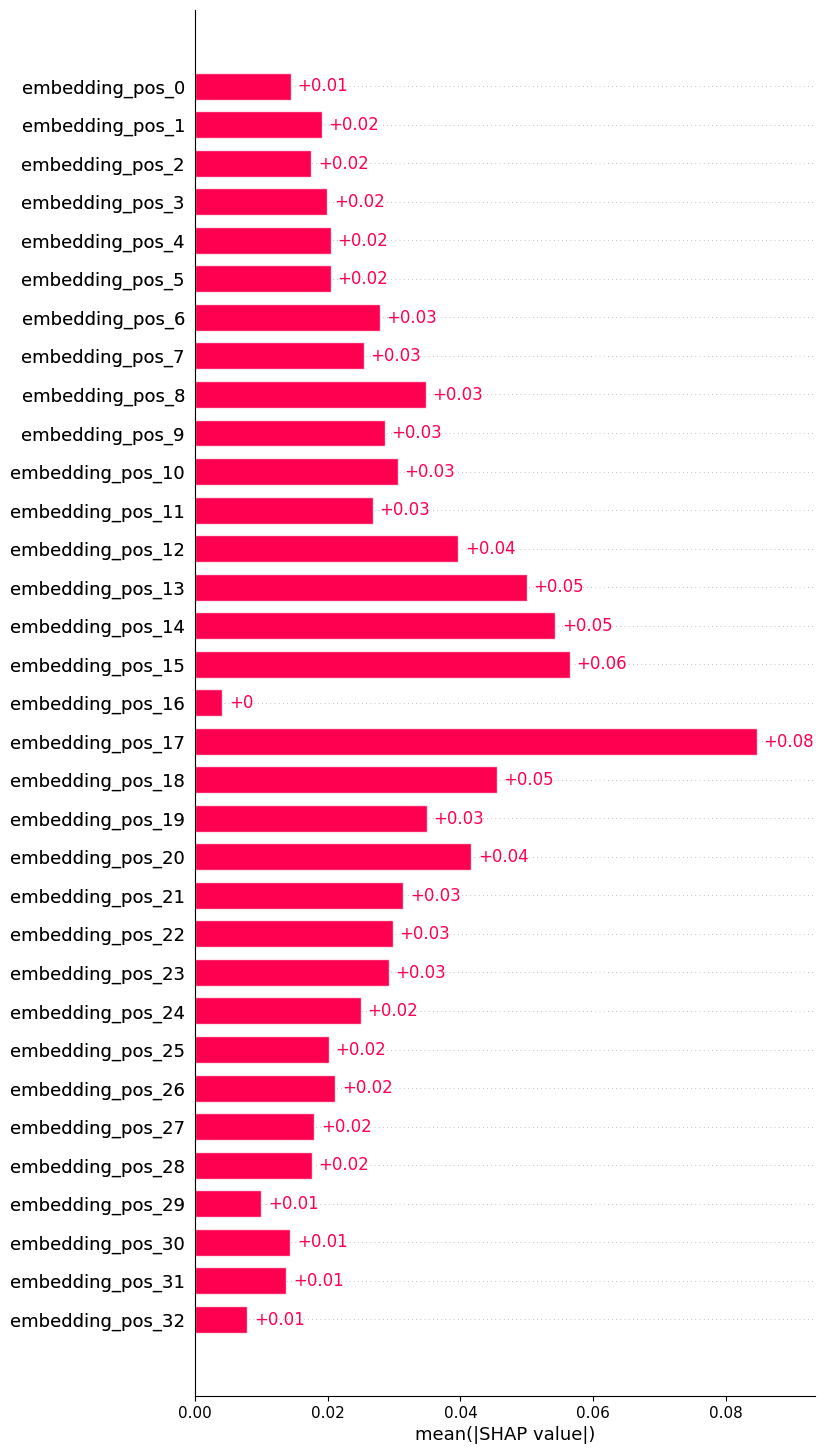

<Figure size 640x480 with 0 Axes>

In [9]:
import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select a single sample for SHAP analysis
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
# Initialize KernelExplainer for SHAP values
shap_explainer = shap.KernelExplainer(conv_branch_model.predict, X_train_num[:100])

# Initialize lists to store SHAP values, distances, and feature names for all proteins
all_shap_values = []

for i in range (100):

    data = test['sequence'].values[i]
    data = [aa_to_int[aa] for aa in data]
    data = np.array(data)
    shap_values = shap_explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values).squeeze())  # Take absolute SHAP values


    # Reshape if needed and create a SHAP Explanation object
    shap_values = shap_values.squeeze()  # Ensure correct shape for visualization
    all_shap_values.append(shap_values)
    # all_distance_values.append(sorted_distance_values)

base_values = shap_explainer.expected_value  # Use model's expected output as base

with open('SHAP/all_shap_values_3.pkl', 'wb') as f:
    pickle.dump(all_shap_values, f)


feature_names = ['embedding_pos_' + str(i) for i in range(33)]

# Create the SHAP Explanation object without flattening
shap_values = shap.Explanation(
    values=all_shap_values,
    base_values=base_values,
    feature_names=feature_names
)

# Visualize SHAP values as a bar plot in original order
ordering = np.arange(len(feature_names))  # Preserve original order
shap.plots.bar(shap_values, max_display=len(feature_names), order=ordering)
plt.savefig("bar_plot.pdf", format="pdf")
plt.show()
plt.close()
   


In [11]:
import pickle
import shap
import numpy as np

# Select a single sample for SHAP analysis
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Initialize KernelExplainer for SHAP values
shap_explainer = shap.KernelExplainer(conv_branch_model.predict, X_train_num[:100])

# Initialize list to store SHAP values and distances for all proteins
shap_and_distances = []

# Loop through proteins and compute SHAP values
for i in range(200):
    try:
        protein_id = test['protein_id'].values[i]
        site = int(test['site'].values[i])
        
        print("Protein ID:", protein_id, "Site:", site)
        # File paths
        pdb_file = f'PDB files new/{protein_id}.pdb'
        distances = calculate_distances(protein_id, site, pdb_file)
    except:
        continue

    if len(distances) != 33:
        continue
    data = train['sequence'].values[i]
    data = [aa_to_int[aa] for aa in data]
    data = np.array(data)
    shap_values = shap_explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values).squeeze())  # Take absolute SHAP values

    # Ensure the order of distances aligns with shap_values
    distance_values = np.array([distances[i] for i in sorted(distances.keys())])
    # Scale the distances
    # distance_values = (distance_values - np.min(distance_values)) / (np.max(distance_values) - np.min(distance_values))

    # Store SHAP values and distances
    shap_and_distances.append((shap_values, distance_values))

# Save SHAP values and distances to a file
with open('SHAP/shap_and_distances_test.pkl', 'wb') as f:
    pickle.dump(shap_and_distances, f)

print("SHAP values and distances saved.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Protein ID: P09030 Site: 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Protein ID: P09030 Site: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P06996 Site: 31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P17854 Site: 102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P17854 Site: 136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P17854 Site: 196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Protein ID: P0AEI1 Site: 287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P0AEI1 Site: 463
Protein ID: P0A884 Site: 2
Protein ID: P0A884 Site: 120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Protein ID: P0AFP6 Si

Average number of residues in each bin: [ 2.          4.54098361  6.17213115 11.09016393  6.89344262  1.30327869]


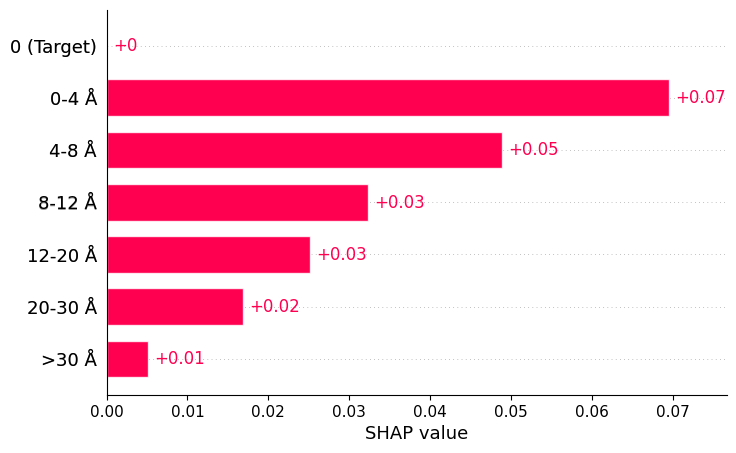

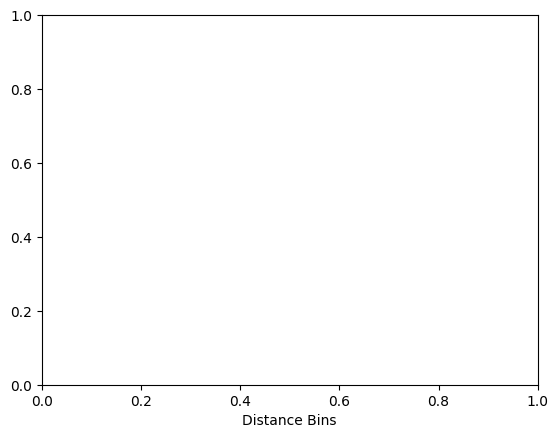

In [2]:
import pickle
import numpy as np
import shap
import matplotlib.pyplot as plt

# Load SHAP values and distances
with open('SHAP/shap_and_distances_test.pkl', 'rb') as f:
    shap_and_distances = pickle.load(f)

def bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels):
    """
    Bin SHAP values by distance using custom bins and plot the results.

    Parameters:
        shap_and_distances: List of tuples (shap_values, distance_values)
        custom_bins: List of distance thresholds to define bins (e.g., [0, 5, 10, 20, 30])
        bin_labels: List of labels for the bins
    """
    all_binned_shap_values = []
    avg_counts = np.zeros(len(custom_bins) - 1)
    for shap_values, distance_values in shap_and_distances:
        # Separate the zero-distance residue and the remaining residues
        zero_distance_mask = distance_values == 0
        non_zero_mask = ~zero_distance_mask

        # Group SHAP values by distance bins
        binned_shap_values = [np.mean(shap_values[zero_distance_mask])]  # Start with the zero-distance group
        for i in range(len(custom_bins) - 1):
            # Mask to select residues in the current bin
            mask = (distance_values >= custom_bins[i]) & (distance_values < custom_bins[i + 1]) & non_zero_mask
            #print number of residues in each bin
            # print("Number of residues in bin", i, ":", np.sum(mask))
            avg_counts[i] += np.sum(mask)
            # Average SHAP values in this bin
            avg_shap_value = np.mean(shap_values[mask]) if np.any(mask) else 0
            binned_shap_values.append(avg_shap_value)

        all_binned_shap_values.append(binned_shap_values)
        

    # Average the binned SHAP values across all proteins
    mean_binned_shap_values = np.mean(all_binned_shap_values, axis=0)

    avg_counts = avg_counts / len(shap_and_distances)

    print("Average number of residues in each bin:", avg_counts)
    # Format the results as a SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=mean_binned_shap_values,
        base_values=0,  # Base value can be set as needed
        feature_names=bin_labels
    )

    ordering = np.arange(len(bin_labels))

    # Plot using shap.plots.bar
    shap.plots.bar(shap_explanation, max_display=len(bin_labels), order=ordering)
    # plt.title("Grouped Absolute SHAP Values (Custom Bins)")
    # plt.savefig(f"grouped_absolute_shap_values_custom_bins.pdf", format="pdf")
    # plt.show()

# Define custom bins and labels
custom_bins = [0, 4, 8, 12, 20, 30, np.inf]  # Example: distances in Angstroms with the last bin as "above 30"
bin_labels = ["0 (Target)", "0-4 Å", "4-8 Å", "8-12 Å", "12-20 Å", "20-30 Å", ">30 Å"]

# Perform binning and plotting
bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels)


Sequence Position-Based SHAP Analysis:


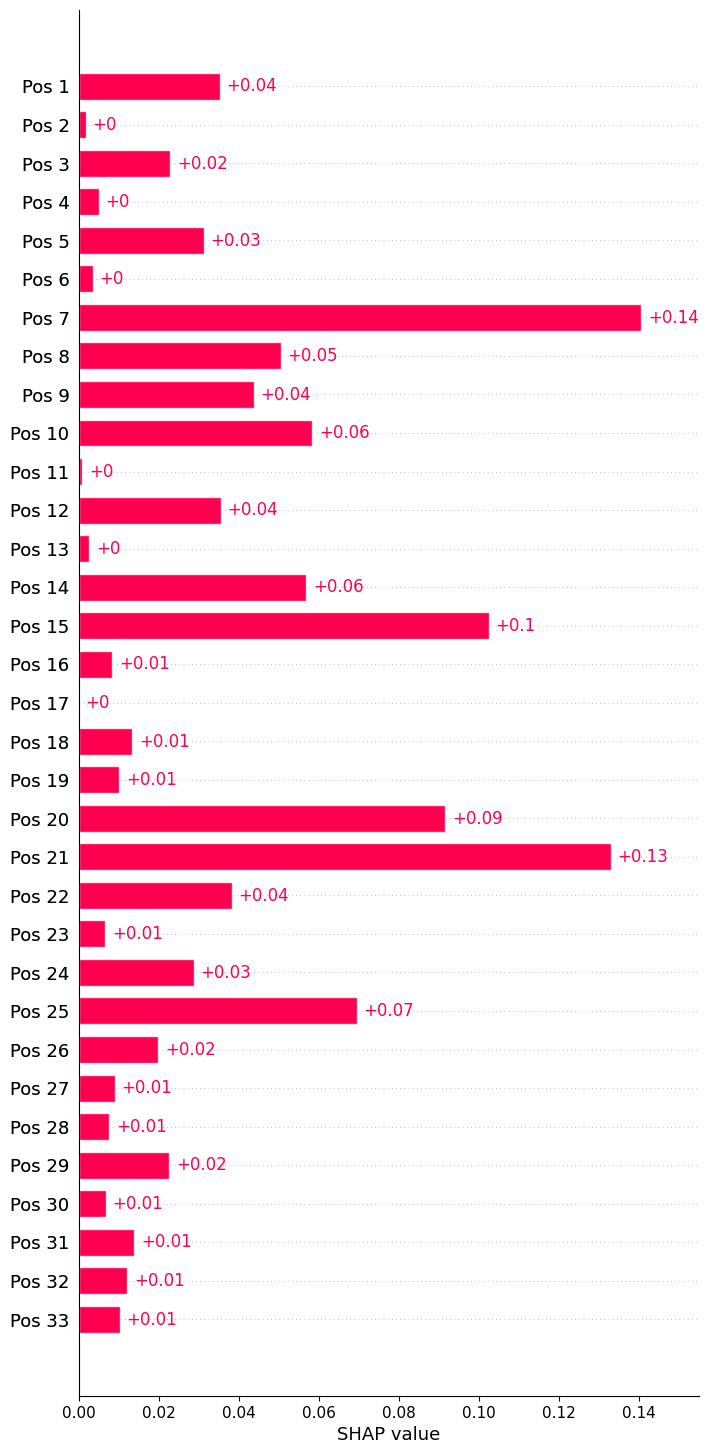

Distance Group-Based SHAP Analysis:


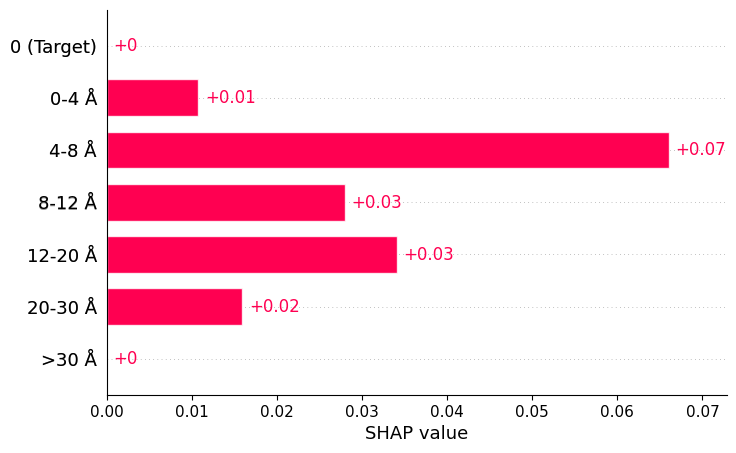

Protein ID: P0AFP6 Site: 69


C:\Users\Admin\AppData\Local\Temp\ipykernel_13308\3558546417.py:71: RuntimeWarning: divide by zero encountered in divide
  plt.bar(range(33), 1/distances, color='blue', alpha=0.5)


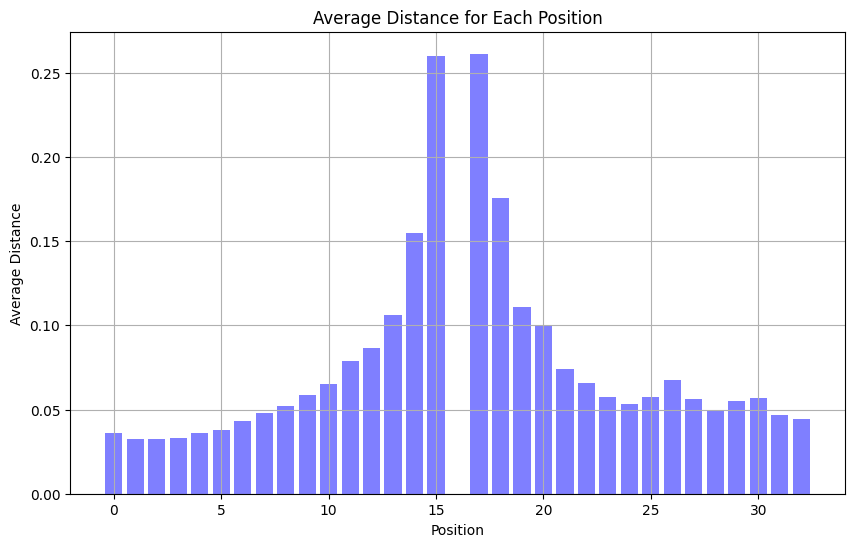

In [35]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import pickle

def analyze_single_protein(protein_index, shap_and_distances, custom_bins, bin_labels, feature_names):
    """
    Perform sequence position-based and distance group-based SHAP analysis for a single protein.

    Parameters:
        protein_index: Index of the protein in the `shap_and_distances` list.
        shap_and_distances: List of tuples (shap_values, distance_values).
        custom_bins: List of distance thresholds to define bins.
        bin_labels: List of labels for the bins.
        feature_names: Feature names for sequence position-based analysis.
    """
    shap_values, distance_values = shap_and_distances[protein_index]

    # --- Sequence Position-Based Analysis ---
    shap_explanation_seq = shap.Explanation(
        values=shap_values,
        base_values=0,
        feature_names=feature_names
    )

    ordering = np.arange(len(feature_names))

    # Plot sequence position-based SHAP values
    print("Sequence Position-Based SHAP Analysis:")
    shap.plots.bar(shap_explanation_seq, max_display=len(feature_names), order=ordering)

    # --- Distance Group-Based Analysis ---
    # Separate the zero-distance residue and the remaining residues
    zero_distance_mask = distance_values == 0
    non_zero_mask = ~zero_distance_mask

    binned_shap_values = [np.mean(shap_values[zero_distance_mask])]  # Zero-distance group
    for i in range(len(custom_bins) - 1):
        # Mask to select residues in the current bin
        mask = (distance_values >= custom_bins[i]) & (distance_values < custom_bins[i + 1]) & non_zero_mask
        avg_shap_value = np.mean(shap_values[mask]) if np.any(mask) else 0
        binned_shap_values.append(avg_shap_value)

    # Format as a SHAP Explanation object
    shap_explanation_dist = shap.Explanation(
        values=binned_shap_values,
        base_values=0,
        feature_names=bin_labels
    )

    ordering = np.arange(len(bin_labels))

    # Plot distance group-based SHAP values
    print("Distance Group-Based SHAP Analysis:")
    shap.plots.bar(shap_explanation_dist, max_display=len(bin_labels), order=ordering)

    try:
        protein_id = test['protein_id'].values[10]
        site = int(test['site'].values[10])
        
        print("Protein ID:", protein_id, "Site:", site)
        # File paths
        pdb_file = f'PDB files new/{protein_id}.pdb'
        distances = calculate_distances(protein_id, site, pdb_file)
        distances = np.array(list(distances.values()))
    except:
        return
    

    plt.figure(figsize=(10, 6))
    plt.bar(range(33), 1/distances, color='blue', alpha=0.5)
    plt.title("Average Distance for Each Position")
    plt.xlabel("Position")
    plt.ylabel("Average Distance")
    plt.grid(True)
    plt.show()


# Feature names for sequence position
sequence_feature_names = [f"Pos {i+1}" for i in range(33)]

# Define custom bins and labels for distance grouping
custom_bins = [0, 4, 8, 12, 20, 30, np.inf]
bin_labels = ["0 (Target)", "0-4 Å", "4-8 Å", "8-12 Å", "12-20 Å", "20-30 Å", ">30 Å"]

with open('SHAP/shap_and_distances.pkl', 'rb') as f:
    shap_and_distances = pickle.load(f)

# Analyze a specific protein (e.g., protein at index 0 in the list)
protein_index = 10  # Replace with the desired index
analyze_single_protein(protein_index, shap_and_distances, custom_bins, bin_labels, sequence_feature_names)


In [11]:
from sklearn.metrics import accuracy_score
import numpy as np

# Make predictions
predictions = conv_branch_model.predict(X_test_num)

# Apply threshold and flatten
predictions = (predictions > 0.5).astype(int).ravel()

# Ensure y_test is flattened and integer-typed
y_test = y_test.ravel().astype(int)

# Check shapes
print("X_test_num shape:", X_test_num.shape)
print("Predictions shape:", predictions.shape)
print("y_test shape:", y_test.shape)

# Verify binary values
print("Unique values in predictions:", np.unique(predictions))
print("Unique values in y_test:", np.unique(y_test))

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Find correct predictions
incorrect_indices = np.where(predictions != y_test)[0]
print("Number of correct predictions:", len(incorrect_indices))


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X_test_num shape: (3226, 33)
Predictions shape: (3226,)
y_test shape: (3226,)
Unique values in predictions: [0 1]
Unique values in y_test: [0 1]
Accuracy: 0.6475511469311841
Number of correct predictions: 1137


In [12]:
import os

# Initialize a list for indices with correct predictions and available PDB files
incorrect_with_pdb_indices = []

# Count the number of missing PDB files
missing_pdb_count = 0

# Iterate through correct indices
for i in incorrect_indices:
    # Get protein ID and check for the corresponding PDB file
    protein_id = test['protein_id'].values[i]
    pdb_file = f'PDB files new/{protein_id}.pdb'

    if os.path.exists(pdb_file):
        # Add to the new index list if PDB file exists
        incorrect_with_pdb_indices.append(i)
    else:
        # Increment missing PDB count
        missing_pdb_count += 1
        print(f"PDB file not found for Protein ID: {protein_id}")

# Print results
print("Number of incorrect predictions:", len(incorrect_indices))
print("Number of incorrect predictions with PDB files:", len(incorrect_with_pdb_indices))
print("Number of missing PDB files:", missing_pdb_count)


PDB file not found for Protein ID: I6XZ95
PDB file not found for Protein ID: I6XZT3
PDB file not found for Protein ID: I6Y098
PDB file not found for Protein ID: I6Y098
PDB file not found for Protein ID: I6Y0P9
PDB file not found for Protein ID: I6Y0P9
PDB file not found for Protein ID: I6Y0Q6
PDB file not found for Protein ID: I6Y0S7
PDB file not found for Protein ID: I6Y1Y2
PDB file not found for Protein ID: I6Y1Y2
PDB file not found for Protein ID: I6Y1Y2
PDB file not found for Protein ID: I6Y1Y2
PDB file not found for Protein ID: 15609376
PDB file not found for Protein ID: YGL189C
PDB file not found for Protein ID: YGL189C
PDB file not found for Protein ID: YER134C
PDB file not found for Protein ID: YFL014W
PDB file not found for Protein ID: YFL014W
PDB file not found for Protein ID: Q9UNM6-2
PDB file not found for Protein ID: Q9UNM6-2
PDB file not found for Protein ID: Q9UNM6-2
PDB file not found for Protein ID: Q9UNM6-2
PDB file not found for Protein ID: Q9UNM6-2
PDB file not foun

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6600/6600 ━━━━━━━━━━━━

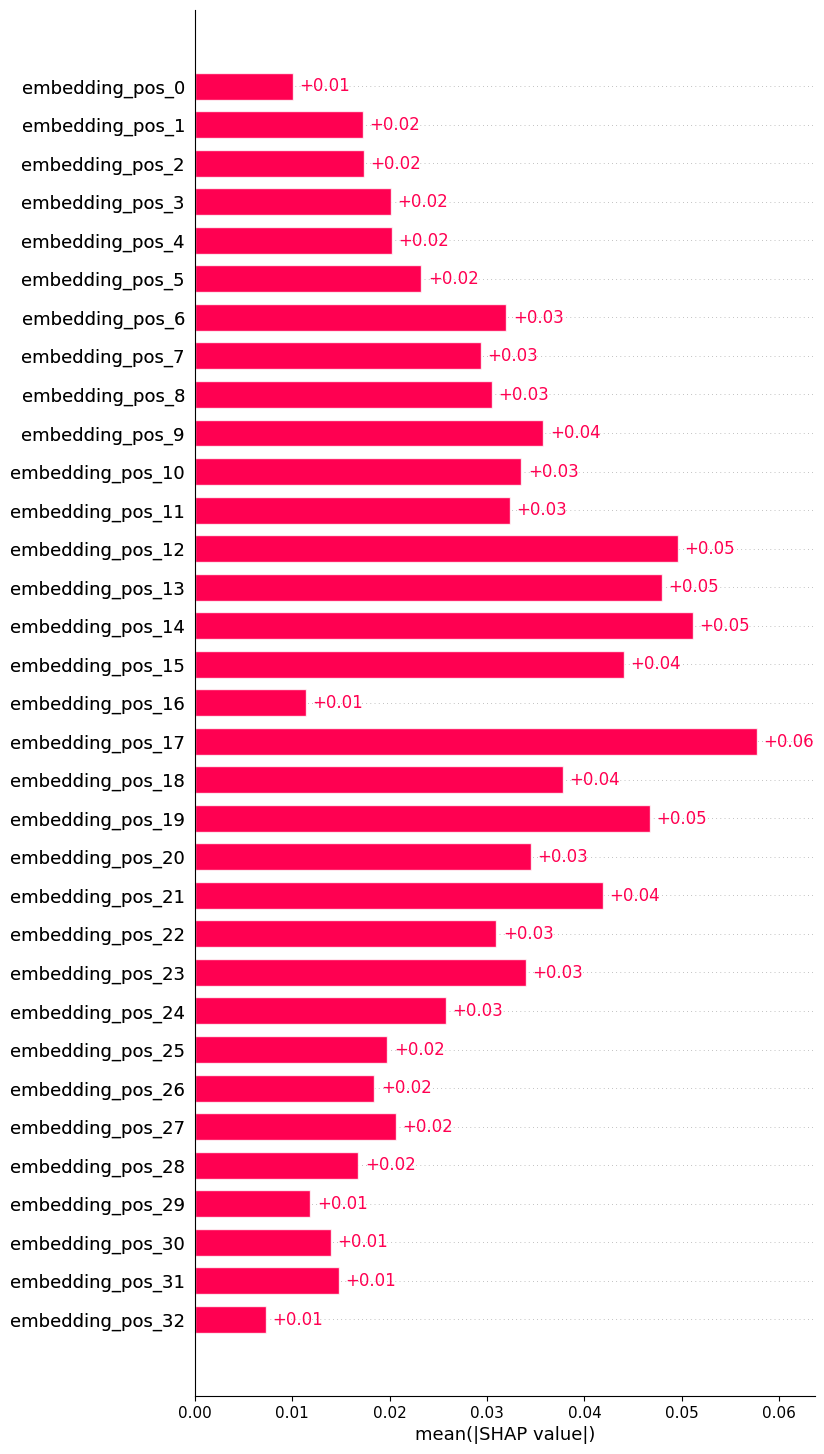

<Figure size 640x480 with 0 Axes>

In [13]:
import random
import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 100 data points from the correct_with_pdb_indices
random_indices = random.sample(incorrect_with_pdb_indices, 100)

# Initialize KernelExplainer for SHAP values
shap_explainer = shap.KernelExplainer(conv_branch_model.predict, X_train_num[:100])

# Initialize lists to store SHAP values
selected_shap_values = []

# Loop through the randomly selected indices
for i in random_indices:
    # Prepare the sequence for SHAP analysis
    data = test['sequence'].values[i]
    data_numeric = np.array([aa_to_int[aa] for aa in data])

    # Compute SHAP values
    shap_values = shap_explainer.shap_values(data_numeric)
    shap_values = np.abs(np.array(shap_values).squeeze())  # Take absolute SHAP values

    # Append SHAP values
    selected_shap_values.append(shap_values)

# Get expected value from SHAP explainer
base_values = shap_explainer.expected_value

# Save the selected SHAP values
with open('SHAP/test_correct.pkl', 'wb') as f:
    pickle.dump(selected_shap_values, f)

# Define feature names (e.g., embedding positions)
feature_names = [f'embedding_pos_{i}' for i in range(33)]

# Create the SHAP Explanation object
shap_explanation = shap.Explanation(
    values=selected_shap_values,
    base_values=base_values,
    feature_names=feature_names
)

# Visualize SHAP values as a bar plot
ordering = np.arange(len(feature_names))  # Preserve original order
shap.plots.bar(shap_explanation, max_display=len(feature_names), order=ordering)
plt.savefig("bar_plot_random_100.pdf", format="pdf")
plt.show()


In [14]:
# Randomly selected indices (already done earlier)
# random_indices = random.sample(correct_with_pdb_indices, 100)

# Define bins and labels for distance-based SHAP grouping
custom_bins = [0, 4, 8, 12, 20, 30, np.inf]
bin_labels = ["0 (Target)", "0-4 Å", "4-8 Å", "8-12 Å", "12-20 Å", "20-30 Å", ">30 Å"]

# Function to calculate SHAP values binned by distances
def bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels):
    all_binned_shap_values = []
    avg_counts = np.zeros(len(custom_bins) - 1)

    for shap_values, distance_values in shap_and_distances:
        # Separate the zero-distance residue and the remaining residues
        zero_distance_mask = distance_values == 0
        non_zero_mask = ~zero_distance_mask

        # Group SHAP values by distance bins
        binned_shap_values = [np.mean(shap_values[zero_distance_mask])]  # Start with the zero-distance group
        for i in range(len(custom_bins) - 1):
            # Mask to select residues in the current bin
            mask = (distance_values >= custom_bins[i]) & (distance_values < custom_bins[i + 1]) & non_zero_mask
            avg_counts[i] += np.sum(mask)
            avg_shap_value = np.mean(shap_values[mask]) if np.any(mask) else 0
            binned_shap_values.append(avg_shap_value)

        all_binned_shap_values.append(binned_shap_values)

    # Average the binned SHAP values across all proteins
    mean_binned_shap_values = np.mean(all_binned_shap_values, axis=0)

    # Report average counts
    avg_counts /= len(shap_and_distances)
    print("Average number of residues in each bin:", avg_counts)

    # Format the results as a SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=mean_binned_shap_values,
        base_values=0,  # Base value can be set as needed
        feature_names=bin_labels
    )

    # Plot using shap.plots.bar
    ordering = np.arange(len(bin_labels))
    shap.plots.bar(shap_explanation, max_display=len(bin_labels), order=ordering)
    plt.savefig("distance_based_bar_plot.pdf", format="pdf")
    plt.show()

# Collect SHAP values and distances for the 100 random indices
shap_and_distances = []
for i in random_indices:
    # Prepare sequence and calculate SHAP values
    data = test['sequence'].values[i]
    data_numeric = np.array([aa_to_int[aa] for aa in data])
    shap_values = shap_explainer.shap_values(data_numeric)
    shap_values = np.abs(np.array(shap_values).squeeze())  # Absolute SHAP values

    # Calculate distances for this protein
    protein_id = test['protein_id'].values[i]
    site = int(test['site'].values[i])  # Assuming 'site' exists in the test DataFrame
    pdb_file = f'PDB files new/{protein_id}.pdb'

    distances = calculate_distances(protein_id, site, pdb_file)
    
    # Append SHAP values and distances for analysis
    shap_and_distances.append((shap_values, distances))

# Perform distance-based SHAP analysis
# bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━

In [15]:
with open('SHAP/shap_and_distances_test_incorrect.pkl', 'wb') as f:
    pickle.dump(shap_and_distances, f)

Mismatch: shap_values (33), distance_values (24)
Mismatch: shap_values (33), distance_values (27)
Mismatch: shap_values (33), distance_values (18)
Mismatch: shap_values (33), distance_values (31)
Mismatch: shap_values (33), distance_values (22)
Mismatch: shap_values (33), distance_values (22)
Mismatch: shap_values (33), distance_values (28)
Mismatch: shap_values (33), distance_values (19)
Mismatch: shap_values (33), distance_values (32)
Mismatch: shap_values (33), distance_values (25)
Mismatch: shap_values (33), distance_values (19)
Mismatch: shap_values (33), distance_values (28)
Average number of residues in each bin: [1.75 4.11 5.41 9.95 5.62 1.32]


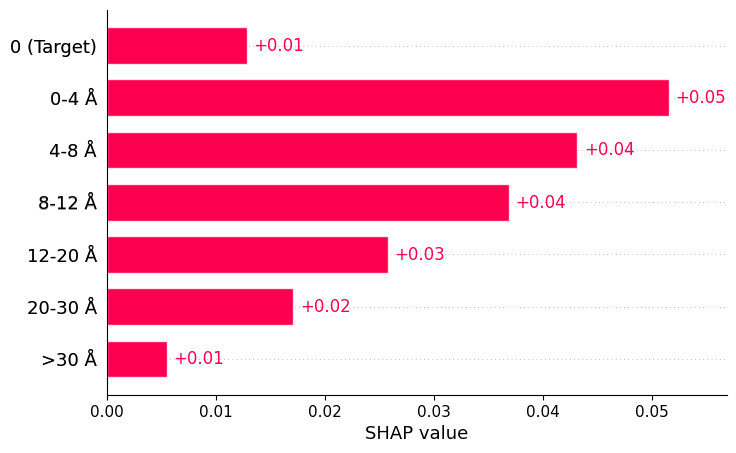

<Figure size 640x480 with 0 Axes>

In [16]:
custom_bins = [0, 4, 8, 12, 20, 30, np.inf]
bin_labels = ["0 (Target)", "0-4 Å", "4-8 Å", "8-12 Å", "12-20 Å", "20-30 Å", ">30 Å"]

# Function to calculate SHAP values binned by distances
def bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels):
    all_binned_shap_values = []
    avg_counts = np.zeros(len(custom_bins) - 1)

    for shap_values, distance_values in shap_and_distances:
        # Separate the zero-distance residue and the remaining residues
        distance_values = np.array(list(distance_values.values()))

        # Debugging: Check if lengths match
        if len(shap_values) != len(distance_values):
            print(f"Mismatch: shap_values ({len(shap_values)}), distance_values ({len(distance_values)})")
            continue

        zero_distance_mask = distance_values == 0
        non_zero_mask = ~zero_distance_mask

        # Group SHAP values by distance bins
        binned_shap_values = [np.mean(shap_values[zero_distance_mask])]  # Start with the zero-distance group
        for i in range(len(custom_bins) - 1):
            # Mask to select residues in the current bin
            mask = (distance_values >= custom_bins[i]) & (distance_values < custom_bins[i + 1]) & non_zero_mask
            avg_counts[i] += np.sum(mask)
            avg_shap_value = np.mean(shap_values[mask]) if np.any(mask) else 0
            binned_shap_values.append(avg_shap_value)

        all_binned_shap_values.append(binned_shap_values)

    # Average the binned SHAP values across all proteins
    mean_binned_shap_values = np.mean(all_binned_shap_values, axis=0)

    # Report average counts
    avg_counts /= len(shap_and_distances)
    print("Average number of residues in each bin:", avg_counts)

    # Format the results as a SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=mean_binned_shap_values,
        base_values=0,  # Base value can be set as needed
        feature_names=bin_labels
    )

    # Plot using shap.plots.bar
    ordering = np.arange(len(bin_labels))
    shap.plots.bar(shap_explanation, max_display=len(bin_labels), order=ordering)
    plt.savefig("distance_based_bar_plot.pdf", format="pdf")
    plt.show()


bin_and_plot_custom(shap_and_distances, custom_bins, bin_labels)


Error processing sample 1: [Errno 2] No such file or directory: 'PDB files new/YGL167C.pdb'
Error processing sample 8: [Errno 2] No such file or directory: 'PDB files new/YEL031W.pdb'
Error processing sample 9: [Errno 2] No such file or directory: 'PDB files new/I6Y628.pdb'


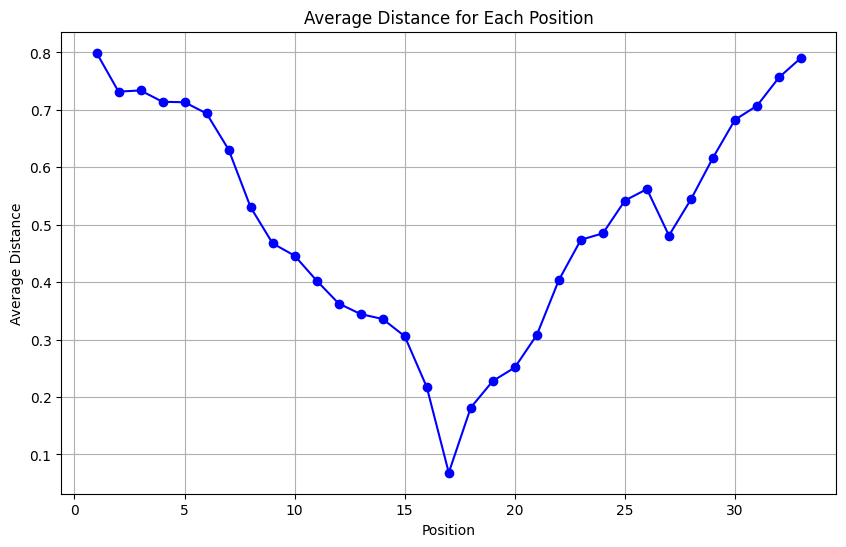

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize an array to accumulate distances for each position
num_positions = 33
distance_accumulator = np.zeros(num_positions)
count_per_position = np.zeros(num_positions)  # To track valid samples for each position

# Map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Iterate through your dataset
for i in range(10):  # Adjust range as needed based on your dataset size
    try:
        # Extract protein_id and site
        protein_id = train['protein_id'].values[i]
        site = int(train['site'].values[i])

        # File paths
        pdb_file = f'PDB files new/{protein_id}.pdb'

        # Calculate distances
        distances = calculate_distances(protein_id, site, pdb_file)

        distances = np.array(list(distances.values()))

        # normalize distances
        distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

    # Accumulate distances for each position
    for pos, dist in enumerate(distances):
        distance_accumulator[pos] += dist
        count_per_position[pos] += 1

# Avoid division by zero when calculating averages
average_distances = np.divide(
    distance_accumulator,
    count_per_position,
    out=np.zeros_like(distance_accumulator),  # Defaults to 0 if division by zero occurs
    where=count_per_position != 0
)

# Plot the average distances
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_positions + 1), average_distances, marker='o', linestyle='-', color='b')
plt.title("Average Distance for Each Position")
plt.xlabel("Position")
plt.ylabel("Average Distance")
plt.grid(True)
plt.show()
